##### Stage 3: Prophet prediction:

In [1]:
# importing necessaries libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from pmdarima.arima.stationarity import ADFTest
from prophet import Prophet

In [2]:
# importing the dataset
room_dt = pd.read_csv('../../Docs/Assets/room.csv')

# converting the index to DateTime
room_dt['Timestamp'] = pd.to_datetime(room_dt['Timestamp'])

# setting the index
room_dt.set_index('Timestamp', inplace=True)

# getting only the index and ApparentTemperature column
apparent_temperature_dataset = room_dt[['ApparentTemperature']].copy()

In [3]:
# getting only the index and ApparentTemperature column
apparent_temperature_data = room_dt.ApparentTemperature

# running ADF Test
adf = ADFTest()
adf.should_diff(apparent_temperature_data)

(0.01, False)

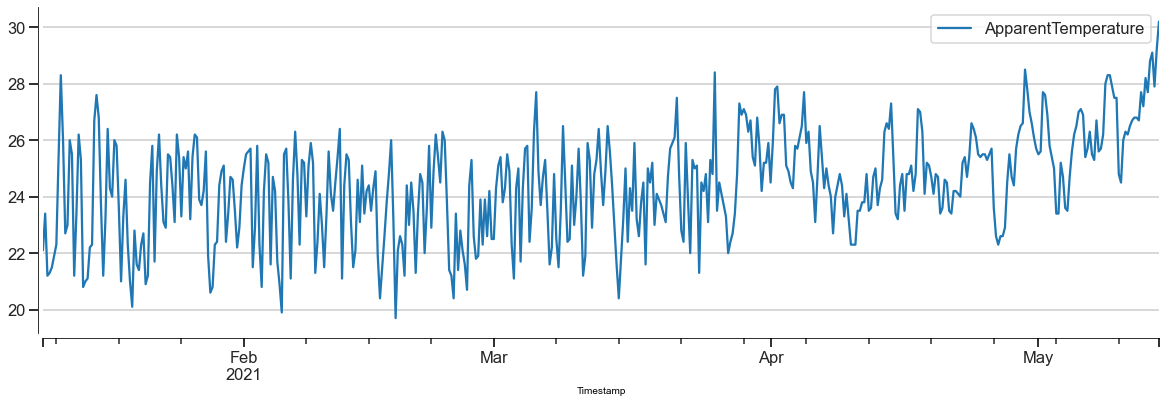

In [4]:
# generating a plot of the data to verify it
fig, ax= plt.subplots(1, 1, figsize=(20, 6))
sns.set_style("ticks")
sns.set_context("talk")

apparent_temperature_dataset.plot(ax=ax)
ax.yaxis.grid(True)
sns.despine(offset=5, trim=False)

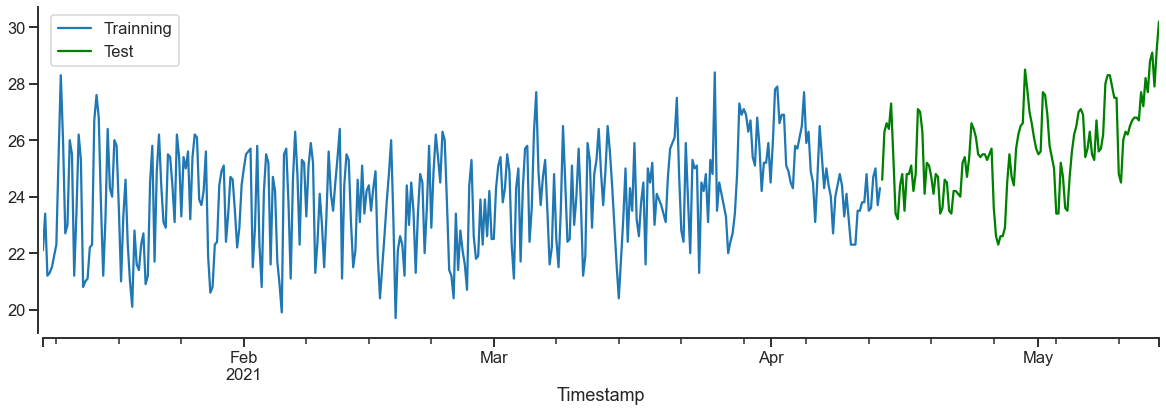

In [5]:
# setting the size of the train, the indexes for trainning and test and the dataset for both
size_of_train = int(np.ceil(apparent_temperature_dataset.shape[0] * 0.75))
idx_train = apparent_temperature_dataset.index[:size_of_train]
idx_test = apparent_temperature_dataset.index[size_of_train:]
train = apparent_temperature_dataset.loc[idx_train]
test = apparent_temperature_dataset.loc[idx_test]

# plotting the train and test data
fig, ax= plt.subplots(1, 1, figsize=(20, 6))
sns.set_style("ticks")
sns.set_context("talk")

ax = train.plot(ax=ax)
test.plot(ax=ax, c="g")
ax.yaxis.grid(False)
ax.legend(["Trainning", "Test"])
sns.despine(offset=5, trim=False)

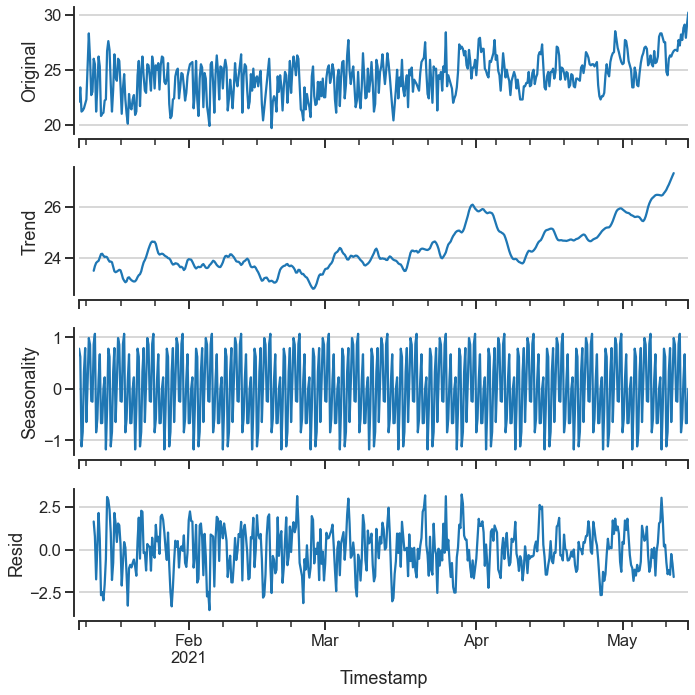

In [6]:
# applying the seasonal decomposition with addtitive parametrs
result = seasonal_decompose(apparent_temperature_dataset, period=24, model="additive")

# plotting the decomposition of the data
fig, axes = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

result.observed.plot(ax=axes[0])
axes[0].set_ylabel("Original")
axes[0].yaxis.grid(True)
result.trend.plot(ax=axes[1])
axes[1].yaxis.grid(True)

axes[1].set_ylabel("Trend")
result.seasonal.plot(ax=axes[2])
axes[2].set_ylabel("Seasonality")
axes[2].yaxis.grid(True)

result.resid.plot(ax=axes[3])
axes[3].set_ylabel("Resid")
axes[3].yaxis.grid(True)

sns.despine(offset=5, trim=False)
fig.tight_layout()

#### Prophet Prediction

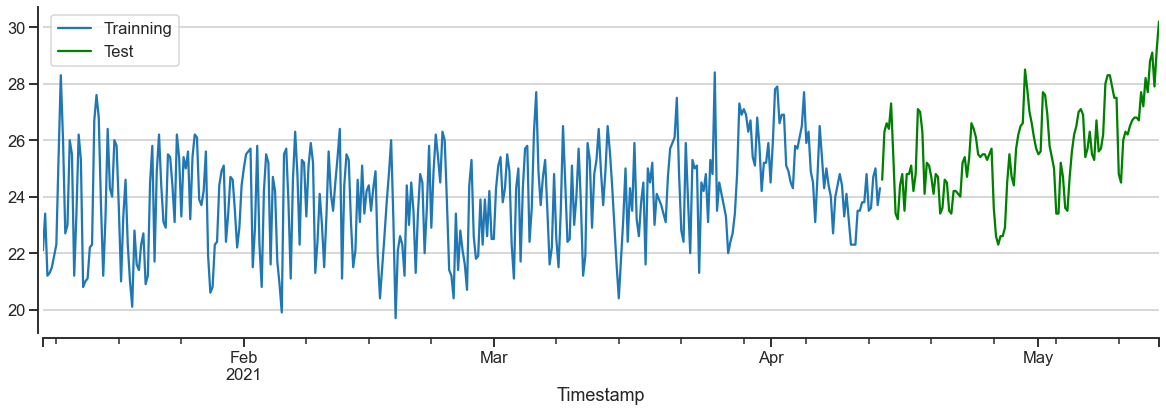

In [7]:
# setting the size of the train, the indexes for trainning and test and the dataset for both for Prophet prediction
size_of_train = int(np.ceil(apparent_temperature_dataset.shape[0] * 0.75))
train = apparent_temperature_dataset.iloc[:size_of_train]
test = apparent_temperature_dataset.iloc[size_of_train:]

# plotting the train and test data
fig, ax= plt.subplots(1, 1, figsize=(20, 6))
sns.set_style("ticks")
sns.set_context("talk")

train.plot(ax=ax)
test.plot(ax=ax, c="g")
ax.yaxis.grid(True)
ax.legend(["Trainning", "Test"])
sns.despine(offset=5, trim=False)

In [8]:
# configuring the Prophet trainning and checking the results
train_prophet = train.reset_index().rename(columns={'Timestamp': 'ds', 'ApparentTemperature': 'y'})
train_prophet.head()

,ds,y
0,2021-01-09 12:00:00,22.1
1,2021-01-09 18:00:00,23.4
2,2021-01-10 00:00:00,21.2
3,2021-01-10 06:00:00,21.3
4,2021-01-10 12:00:00,21.5


In [9]:
# initializing the Prophet model and fitting it
model = Prophet()
model.fit(train_prophet)

# setting the period for the Prophet model
periods = apparent_temperature_dataset.shape[0] - size_of_train

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [10]:
# configuring the Prophet prediction
far_future = model.make_future_dataframe(int(round(periods, 0)*2.25), freq="6h")

# predicting the data
far_forecast = model.predict(far_future)

# convertting the data to a dataframe
prophet_prediction_filtered = far_forecast[['ds', 'yhat']].copy()

# exporting and saving it to a CSV file
prophet_prediction_filtered.to_csv('../../Docs/Assets/prophet_prediction.csv')

# generating the CSV file with the prediction data and saving it in the local Modelling folder
prophet_prediction_filtered.to_csv('../../Data/Modeling/prophet_prediction.csv')

In [11]:
# Source: https://weather.com/weather/monthly/l/Minato+ku+Tokyo+Prefecture+Japan?canonicalCityId=88531c440be4859e58ca9bee96a8fef95643429857e3c626542368c9cb3c4815

# getting the data from the CSV file with all temperatures in Japan for the period
all_temperatures_japan = pd.read_csv('../../Docs/Assets/real_temperatures_japan.csv')

# converting the Timestamp to DateTime
all_temperatures_japan['Timestamp'] = pd.to_datetime(all_temperatures_japan.Timestamp)

# setting the index
all_temperatures_japan.set_index('Timestamp', inplace=True)

# filling empty rows with duplicated previous values
temperatures_processed = all_temperatures_japan.copy().resample('6h').ffill()

# getting only the temperatures for the period in analysis
temperatures_processed = temperatures_processed[:'2021-06-22 12:00:00']

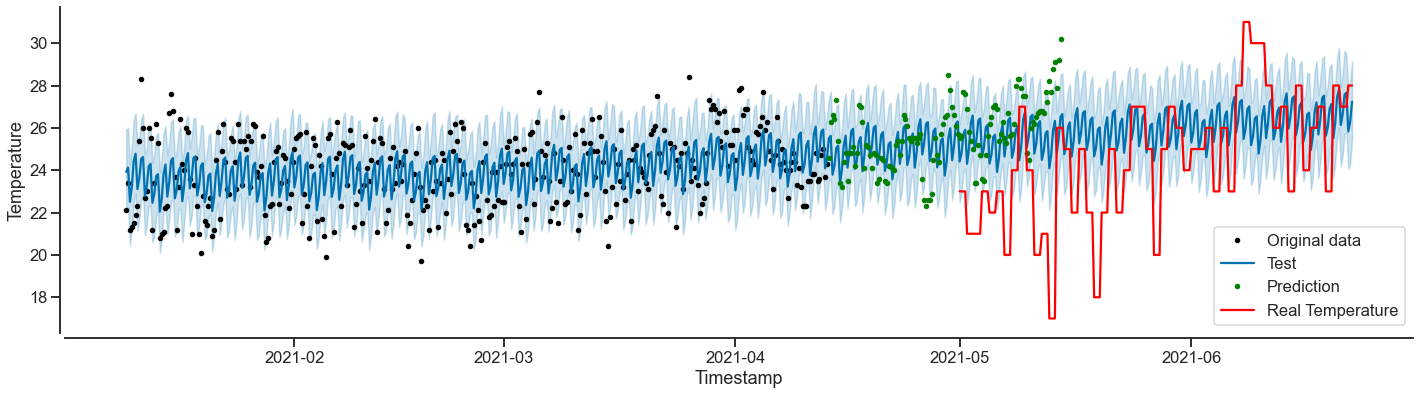

In [12]:
# configuring the plot
fig, ax= plt.subplots(1, 1, figsize=(20, 6))
sns.set_style("ticks")
sns.set_context("talk")

# plotting the Prophet's prediction
model.plot(far_forecast, ax=ax, xlabel='Date', ylabel='Temperature');

# plotting the Test data
test.plot(ax=ax, c="g",marker='.', linestyle='None');

# plotting the original weather data from Japan on the same period
temperatures_processed.plot(ax=ax, c="r")

# adding grid to the plot
# ax.yaxis.grid(True)

# adding the legend on the plot
plt.legend(["Original data", "Test", "Prediction", "Real Temperature"])

# adding a little space between the plot's X and Y axis
sns.despine(offset=5, trim=False)